In [1]:
import warnings

warnings.filterwarnings('ignore')

from math import log, pi

import matplotlib.pyplot as plt
import ngboost as ng
import ngflowboost as ngbf
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch import optim
from tqdm import tqdm

from sklearn.metrics import mean_squared_error

from models.flow import build_model
from utils.datasets import load_regression_dataset


DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)


def gaussian_log_likelihood(x, mean, logvar, clip=True):
    if clip:
        logvar = torch.clamp(logvar, min=-4, max=3)
    a = log(2 * pi)
    b = logvar
    c = (x - mean) ** 2 / torch.exp(logvar)
    return -0.5 * (a + b + c)


def standard_normal_logprob(z):
    dim = z.size(-1)
    log_z = -0.5 * dim * log(2 * pi)
    return log_z - z.pow(2) / 2


cuda


In [2]:
def _generate_data(n=100, std=0.1):
    eps = std * np.random.randn(n)
    x = np.random.rand(n) * 4*np.pi - 2*np.pi
    y = np.sin(x) + eps
    return x, y


def generate_data(n=100, std=0.1):
    x1, y1 = _generate_data(n=n, std=std)
    x2, y2 = _generate_data(n=n, std=std)
    y2 = -y2
    return (
        np.concatenate([x1, x2]),
        np.concatenate([y1, y2])
    )

In [3]:
x, y = generate_data(n=300, std=0.1)

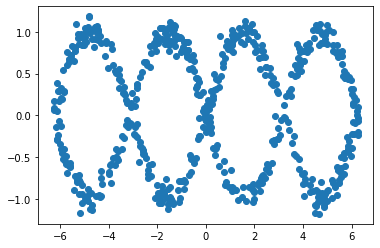

In [4]:
plt.scatter(x, y)
plt.show()

In [5]:
X_train, y_train = x.reshape(-1, 1), y
X_test, y_test = generate_data(100)
X_test = X_test.reshape(-1, 1)

In [6]:
model = ng.NGBRegressor()

model.fit(X_train, y_train)

y_test_hat = model.predict(X_test)
mean_squared_error(y_test, y_test_hat)

[iter 0] loss=1.0870 val_loss=0.0000 scale=2.0000 norm=1.5314
[iter 100] loss=0.9519 val_loss=0.0000 scale=2.0000 norm=1.4016
[iter 200] loss=0.8528 val_loss=0.0000 scale=2.0000 norm=1.3220
[iter 300] loss=0.7668 val_loss=0.0000 scale=2.0000 norm=1.2568
[iter 400] loss=0.7101 val_loss=0.0000 scale=2.0000 norm=1.2129


0.5063434583082501

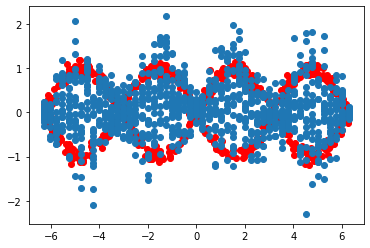

In [7]:
n_samples = 20

x_new = torch.linspace(-2*np.pi, 2*np.pi, 51).repeat(n_samples).reshape(-1, 1)
y_params = model.pred_param(x_new)
y_samples = model.pred_dist(x_new).sample(1)

# plt.errorbar(x_new, y_params[:, 0], yerr=np.exp(y_params[:, 1]), fmt='o')
plt.scatter(x, y, c='red')
plt.scatter(x_new, y_samples)
plt.show()

In [8]:
from sklearn.preprocessing import OneHotEncoder

In [9]:
mu_models = [n[0] for n in model.base_models]
logvar_models = [n[1] for n in model.base_models]

In [10]:
mu_leafs = np.vstack([m.apply(X_train) for m in mu_models]).T
logvar_leafs = np.vstack([m.apply(X_train) for m in logvar_models]).T

In [11]:
mu_leafs_encoder = OneHotEncoder(sparse=False).fit(mu_leafs)
logvar_leafs_encoder = OneHotEncoder(sparse=False).fit(logvar_leafs)

mu_leafs_encoded = mu_leafs_encoder.transform(mu_leafs)
logvar_leafs_encoded = logvar_leafs_encoder.transform(logvar_leafs)

In [12]:
context = np.hstack([mu_leafs_encoded, logvar_leafs_encoded])

In [13]:
context

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [14]:
flow = build_model(
    input_dim=1,
    hidden_dims=(40,40,40),
    context_dim=20,
    conditional=True,
    time_length=1.0,
    batch_norm=True,
    layer_type="concatsquash"
).to(DEVICE)

context_encoder = nn.Sequential(
    nn.Linear(context.shape[1], 20),
    nn.Tanh(),
).to(DEVICE)

optimizer = optim.Adam(list(flow.parameters()) + list(context_encoder.parameters()))

In [15]:
X_train_params = model.pred_param(X_train)

mean = torch.Tensor(X_train_params[:, 0]).to(DEVICE)
logvar = torch.Tensor(X_train_params[:, 1]).to(DEVICE)

context = torch.Tensor(context).to(DEVICE)
x = torch.Tensor(y_train).reshape(-1, 1).to(DEVICE)

In [16]:
num_iter = 250

with tqdm(range(num_iter)) as pbar:
    for i in pbar:
        optimizer.zero_grad()

        zero = torch.zeros(x.shape[0], 1).to(DEVICE)

        context_e = context_encoder(context)
        z, delta_logp = flow(x=x, context=context_e, logpx=zero)

        logpz = standard_normal_logprob(z)
        logpx = logpz - delta_logp

        loss = -logpx.mean()
        
        loss.backward()
        optimizer.step()
        
        pbar.set_description(str(loss.item()))

-1.0775275230407715: 100%|██████████| 250/250 [01:32<00:00,  2.71it/s] 


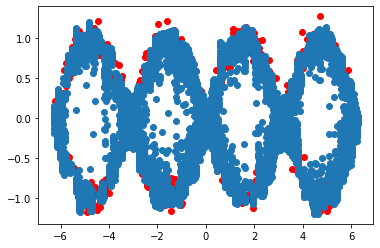

In [19]:
n_samples = 20

x_new = torch.linspace(-2*np.pi, 2*np.pi, 501).repeat(n_samples).reshape(-1, 1)

mu_leafs = np.vstack([m.apply(x_new) for m in mu_models]).T
logvar_leafs = np.vstack([m.apply(x_new) for m in logvar_models]).T

mu_leafs_encoded = mu_leafs_encoder.transform(mu_leafs)
logvar_leafs_encoded = logvar_leafs_encoder.transform(logvar_leafs)

context = np.hstack([mu_leafs_encoded, logvar_leafs_encoded])
context = torch.Tensor(context).to(DEVICE)
context_e = context_encoder(context)

y_params = torch.Tensor(model.pred_param(x_new)).to(DEVICE)
x_new = x_new.to(DEVICE)

z = torch.randn(len(x_new), 1).to(DEVICE)

y_new = flow(x=z, context=context_e, reverse=True)
y_new = y_new.detach().cpu().numpy()

x, y = generate_data(n=300, std=0.1)
plt.scatter(x, y, c='red')
plt.scatter(x_new.detach().cpu().numpy(), y_new)
plt.show()